In [1]:
"""
Load:
  x_a_init.txt
Save:
  x_b.txt
  x_a.txt
"""
import numpy as np
from scipy.integrate import ode
import lorenz96
import matplotlib.pyplot as plt
from settings import *
import matplotlib.pyplot as plt

In [268]:
def locallization(B):
    W = np.zeros([40,40])
    L=5 
    
    for i in range(40):
        for j in range(40):
            d_i = np.mod(np.abs(i+40-j),40)
            d_j = np.mod(np.abs(j+40-i),40)
            d = np.min([d_i,d_j])
            W[i,j] = np.exp(-1*d**2/2/L**2)

    return np.multiply(W,B)

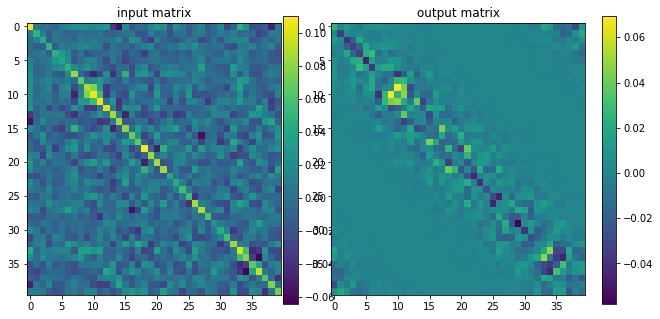

In [271]:
test_matrix = np.ones([40,40])
#print(locallization(test_matrix))


fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('input matrix')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('output matrix')
plt.imshow(np.reshape(locallization(HPH),[40,40])-B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [ ]:
nT = 800
nk = 40
#set random seed
np.random.seed(201910)

#load true value
x_t_save = np.genfromtxt('x_t.txt')

# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
analysis_error = 25.e-2
#load background error covariance matrix
B = np.genfromtxt('B.txt')

np.random.seed(20191031)
# create observations

observation_error = 25.e-2
y_o_save = np.zeros([nT+1, N])
y_o_save = x_t_save + observation_error * np.random.randn(nT+1, N)
#print(y_o_save[tt-1].shape)

# initial x_b: no values at the initial time (assign NaN)
#x_b_save = np.full((1,N), np.nan, dtype='f8')
x_b_save = np.array([x_a_init])

#x_b_save = np.reshape(x_t_save[0],[1,40])

# initial x_a: from x_a_ens_init

x_a_save = np.array([x_a_init])
print("x_a_save shape = ",x_a_save.shape)

tt = 0
R = 0.25 * np.identity(40) #observation error covariance

B_temp_2 = B.copy()
B_a = np.reshape(B_temp_2,[40,40,1])
B_f = np.reshape(B_temp_2,[40,40,1])
H = np.identity(40)

while tt <= nT:
    ttf = tt + 1
    Ta = tt  * dT  # forecast start time(DA time)
    Tf = ttf * dT  # forecast end time
    print('Cycle =', tt, ', Ta =', round(Ta, 10), ', Tf =', round(Tf, 10))
    
    # background
    if tt ==0:
        B = B.copy()
        K_i = np.dot(B, np.dot(H, np.linalg.inv(np.dot(H, np.dot(B,H))+R)))
        K = np.reshape(K_i, [1,40,40])

    else:
        k_i = np.split(K,ttf)[tt]
    for e in range(nk):
        #--------------
        # analysis step
        #--------------
        x_b = x_b_save[tt].transpose()

        # observation
        y_o = y_o_save[tt].transpose()
        #perturb observation
        np.random.seed(20191130+e)
        y_o_k = y_o + observation_error * np.random.randn(N)
        #print(y_o_k.shape)
        
        # innovation

        y_b = np.dot(H, x_b)
        d = y_o_k - y_b
        #print(x_a_k_save.shape)
        x_a = x_b + np.dot(K_i,d)
        
        #print(np.reshape(x_a,[1,40]).shape)
        
        
        if e == 0:
            x_a_k_save = np.reshape(x_a.transpose(),[1,40])
        else:
            #print()
            x_a_k_save = np.vstack([x_a_k_save, np.reshape(x_a,[1,40])])
        #--------------
        # forecast step
        #--------------
        np.random.seed(20181130+e)
        #print(x_a_k_save[tt].shape)
        solver = ode(lorenz96.f).set_integrator('dopri5')
        solver.set_initial_value(x_a.transpose() + observation_error * np.random.randn(N), Ta).set_f_params(F)
        solver.integrate(Tf)
        if e == 0:
            x_b_k_save = np.array([solver.y])
        else:
            x_b_k_save = np.vstack([x_b_k_save, [solver.y]])

    x_a_k_mean = np.mean(x_a_k_save, axis = 0)
    x_b_k_mean = np.mean(x_b_k_save, axis = 0)
    x_b_save = np.vstack([x_b_save,x_b_k_mean])
    x_a_save = np.vstack([x_a_save, x_a_k_mean])
    print(x_a_save.shape)
    
    #do the poll
    

    PH = np.cov(x_b_k_save,rowvar = False)
    HPH = np.cov(x_b_k_save,rowvar = False)

    #print(np.trace(PH))
    K_ip1 = np.dot(locallization(PH), np.linalg.inv(locallization(HPH)+R))

    K = np.concatenate((K, np.reshape(K_ip1,[1,40,40])), axis =0)
    print(np.trace(PH))
    tt += 1

#save background and analysis data
print(x_b_save.shape)
print(x_a_save.shape)
x_b_save = x_b_save[0:801][:]
x_a_save = x_a_save[1:802][:]
print(x_b_save.shape)
print(x_a_save.shape)
np.savetxt('x_b.txt', x_b_save)
np.savetxt('x_a.txt', x_a_save)

x_a_save shape =  (1, 40)
Cycle = 0 , Ta = 0.0 , Tf = 0.05
(2, 40)
2.7049429628758963
Cycle = 1 , Ta = 0.05 , Tf = 0.1
(3, 40)
2.6886831732925778
Cycle = 2 , Ta = 0.1 , Tf = 0.15
(4, 40)
2.6892395640456095
Cycle = 3 , Ta = 0.15 , Tf = 0.2
(5, 40)
2.6940940767047414
Cycle = 4 , Ta = 0.2 , Tf = 0.25
(6, 40)
2.6942613545965983
Cycle = 5 , Ta = 0.25 , Tf = 0.3
(7, 40)
2.6894582599273127
Cycle = 6 , Ta = 0.3 , Tf = 0.35
(8, 40)
2.6834618481720645
Cycle = 7 , Ta = 0.35 , Tf = 0.4
(9, 40)
2.681630862108247
Cycle = 8 , Ta = 0.4 , Tf = 0.45
(10, 40)
2.6860086134589514
Cycle = 9 , Ta = 0.45 , Tf = 0.5
(11, 40)
2.694542230322238
Cycle = 10 , Ta = 0.5 , Tf = 0.55
(12, 40)
2.7077254883963184
Cycle = 11 , Ta = 0.55 , Tf = 0.6
(13, 40)
2.721954292353127
Cycle = 12 , Ta = 0.6 , Tf = 0.65
(14, 40)
2.7355452967217726
Cycle = 13 , Ta = 0.65 , Tf = 0.7
(15, 40)
2.7507496368104585
Cycle = 14 , Ta = 0.7 , Tf = 0.75
(16, 40)
2.7630861244826073
Cycle = 15 , Ta = 0.75 , Tf = 0.8
(17, 40)
2.772259940934596
Cycl

In [ ]:
bias_v = []
rmse_v = []
for i in range(N):
    pt = i
    plt.figure()
    #print(x_a_save[:,pt-1])
    #print(x_b_save[:,pt-1])
    
    plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
    plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
    bias_i = (x_b_save[:,pt-1]-x_t_save[:,pt-1]).mean()
    print("bias = ", bias_i)
    rmse_i = np.std(x_b_save[:,pt-1]-x_t_save[:,pt-1])
    print("rmse = ", rmse_i)
    bias_v.append(bias_i)
    rmse_v.append(rmse_i)
    
    
    plt.xlabel(r'$t$', size=18)
    plt.ylabel(r'$x$', size=18)
    plt.xlim(0,3)
    plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
    plt.legend(loc='upper right', numpoints=1, prop={'size':18})
    #plt.savefig('timeseries.png', dpi=200)
    plt.show()
    plt.close()

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('B_mean')
plt.imshow(np.reshape(k_i,[40,40])-B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.set_title('B')
plt.imshow(HPH,vmin=-0.02,vmax=0.25)
ax.set_aspect('auto')
cax = fig.add_axes([0.26, 0.1, 0.26, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('K')
plt.imshow(B)
ax2.set_aspect('auto')

cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(141)
ax.set_title('colorMap')
plt.imshow(x_t_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax.set_aspect('auto')

ax2 = fig.add_subplot(142)
ax2.set_title('colorMap')
plt.imshow(y_o_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax2.set_aspect('auto')


ax3 = fig.add_subplot(143)
ax3.set_title('colorMap')
plt.imshow(x_a_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax3.set_aspect('auto')


ax4 = fig.add_subplot(144)
ax4.set_title('colorMap')
plt.imshow(x_b_save-x_t_save, cmap = "bwr", vmin=-0.3, vmax=0.3)
ax4.set_aspect('auto')


cax = fig.add_axes([0.26, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()